In [104]:
import pandas as pd
import matplotlib as mlt
import matplotlib.pyplot as plt
mlt.rcParams['figure.figsize'] = (10,8)
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly
import plotly.offline as py
from fbprophet.diagnostics import cross_validation, performance_metrics


In [47]:
df = pd.read_csv("nyc_electricity_consumption.csv")

In [48]:
df.head(3)

timeStamp  demand  precip   temp
0  2012-01-01 00:00:00  4937.5     0.0  46.13
1  2012-01-01 01:00:00  4752.1     0.0  45.89
2  2012-01-01 02:00:00  4542.6     0.0  45.04

In [49]:
df.dtypes

timeStamp     object
demand       float64
precip       float64
temp         float64
dtype: object

In [50]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

In [51]:
df= df.set_index('timeStamp')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000A11A8E8518>,
      dtype=object)

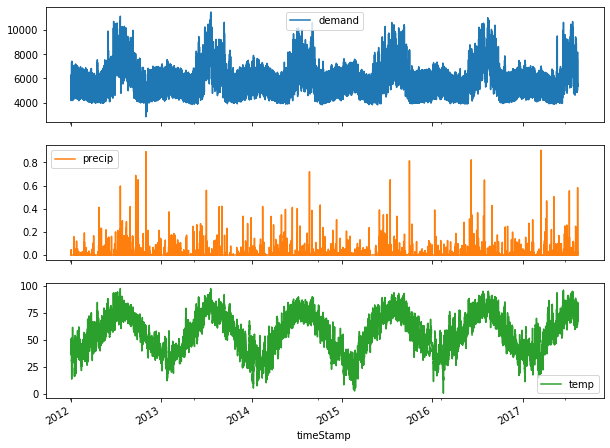

In [27]:
df.plot(subplots=True)

In [52]:
df = df.resample('D').mean()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000A11AC5D908>,
      dtype=object)

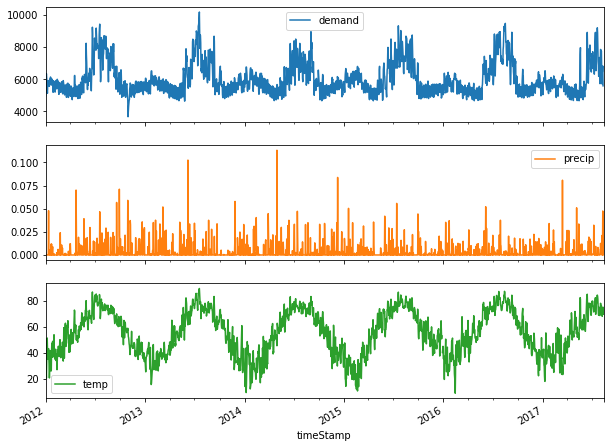

In [30]:
df.resample('D').mean().plot(subplots=True)

###  FACEBOOK PROPHET
### y(t) = g(t) + s(t) + h(t) + z(t)

In [53]:
df = df.reset_index()[['timeStamp','demand']].rename({'timeStamp':'ds','demand':'y'},axis=1)

In [56]:
train = df[(df['ds']>= '2012-01-01') & (df['ds']<='2017-04-30')]

In [58]:
test = df[(df['ds']> '2017-04-30')]

In [78]:
test.shape

(104, 2)

In [61]:
m = Prophet(interval_width=0.95,yearly_seasonality=True)

In [62]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [64]:
m.params


OrderedDict([('k', array([[0.08595257]])),
             ('m', array([[0.59374945]])),
             ('delta',
              array([[-6.33858637e-08, -1.90547086e-05, -1.00535533e-01,
                      -5.78076397e-07,  6.44775818e-11,  1.88828742e-08,
                       3.91974159e-08, -3.01463834e-08, -2.03954325e-07,
                      -1.29907008e-08, -2.75044009e-02, -7.06790158e-02,
                      -8.42375967e-04, -8.13331863e-08,  2.36800777e-01,
                       7.56481624e-03,  2.00110172e-07, -9.23195136e-02,
                      -5.16563271e-02,  5.29329477e-08, -4.80089378e-08,
                       9.74313896e-08,  1.13641393e-02,  5.91529564e-03,
                       1.14883552e-07]])),
             ('sigma_obs', array([[0.04598931]])),
             ('beta',
              array([[-0.03464173, -0.07052822,  0.05759362,  0.04706025, -0.01407079,
                      -0.00500229, -0.00387182, -0.00073864,  0.00241469, -0.00755862,
                 

In [68]:
#future = m.make_future_dataframe(periods=104)
future.tail()

ds
2046 2017-08-08
2047 2017-08-09
2048 2017-08-10
2049 2017-08-11
2050 2017-08-12

In [72]:
forecast = m.predict(future)

In [76]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

ds         yhat   yhat_lower   yhat_upper
0 2012-01-01  5104.287807  4250.270045  5986.192239
1 2012-01-02  5788.812562  4855.077932  6689.238618
2 2012-01-03  5905.962359  5061.911790  6842.069511
3 2012-01-04  5913.736265  5041.744367  6799.389509
4 2012-01-05  5884.443356  4966.780859  6768.574455

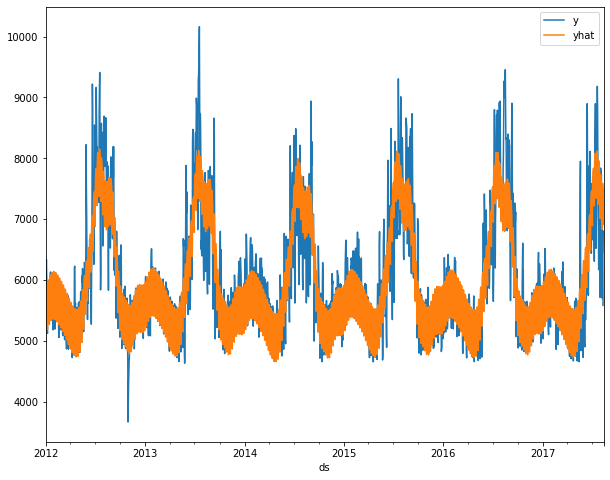

In [82]:
pd.concat([df.set_index('ds')['y'],forecast.set_index('ds')['yhat']],axis=1).plot()

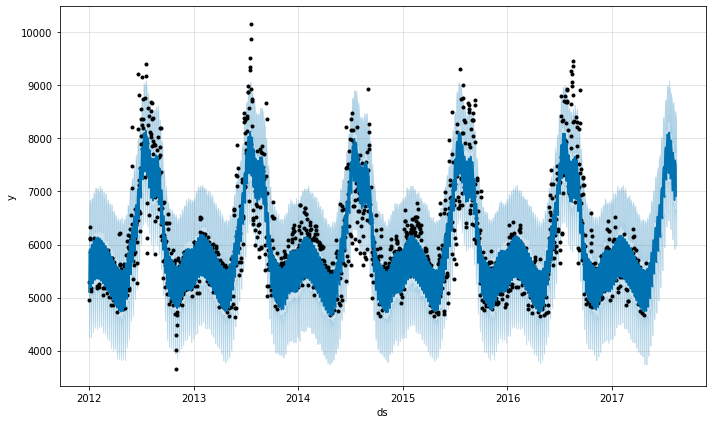

In [84]:
m.plot(forecast)
plt.show()

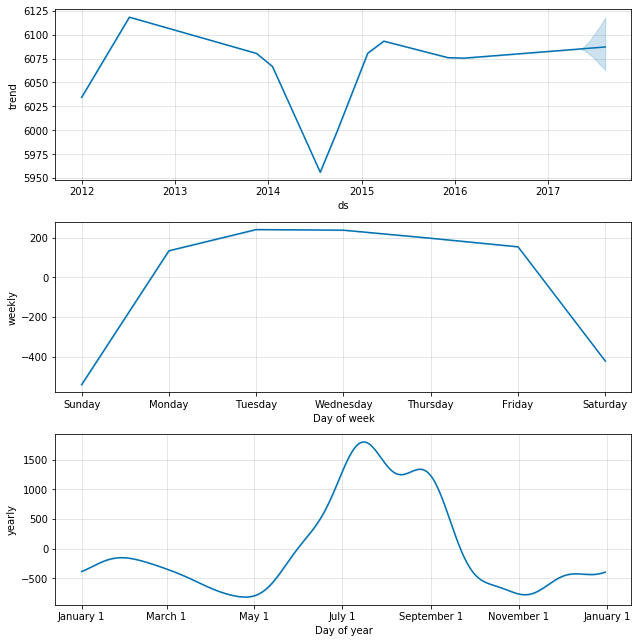

In [87]:
m.plot_components(forecast)
plt.show()

In [91]:
df.head(1)

ds            y
0 2012-01-01  4954.833333

### ADDING CHANGE POINTS

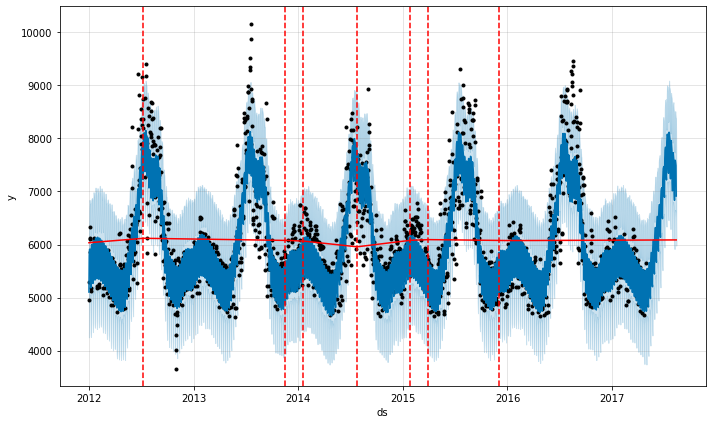

In [90]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


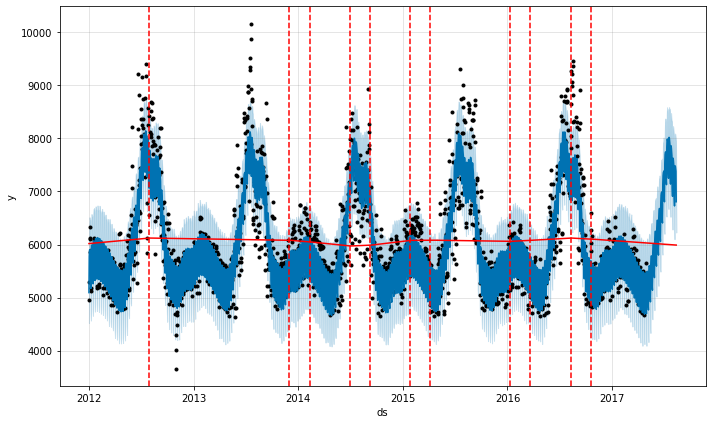

In [92]:
pro_change = Prophet(changepoint_range = 0.9, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig = pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(),pro_change, forecast)

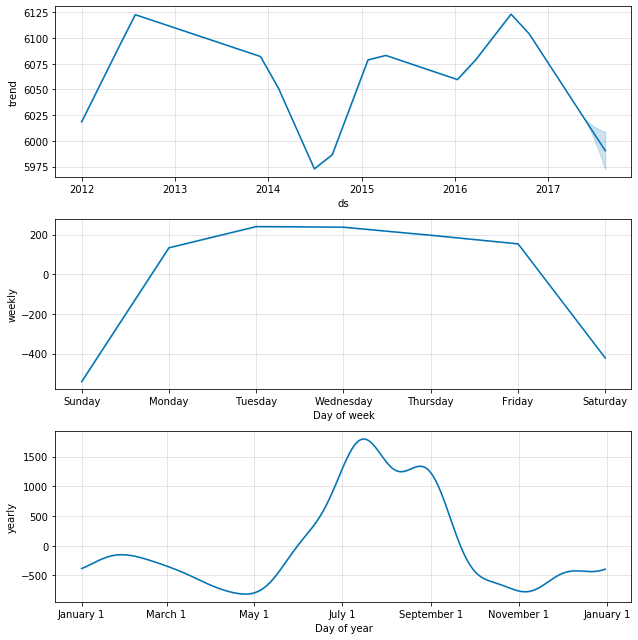

In [93]:
m.plot_components(forecast)
plt.show()

In [96]:
fig = plot_plotly(m,forecast)
py.iplot(fig)

In [99]:
cv_resuts = cross_validation(model = m , initial='731 days', horizon= '365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


In [102]:
cv_resuts.head()

ds         yhat   yhat_lower   yhat_upper            y     cutoff
0 2014-05-02  5565.163424  4750.208371  6408.950292  5460.325000 2014-05-01
1 2014-05-03  4975.296264  4122.152453  5871.683475  4893.683333 2014-05-01
2 2014-05-04  4851.558917  4053.070226  5718.662607  4764.137500 2014-05-01
3 2014-05-05  5532.583407  4680.712849  6362.918901  5406.762500 2014-05-01
4 2014-05-06  5627.631037  4751.434588  6462.124026  5409.750000 2014-05-01

In [106]:
df_p = performance_metrics(cv_resuts)

In [107]:
df_p

horizon            mse        rmse         mae      mape  \
0    36 days 12:00:00  253807.248160  503.792862  407.863449  0.073333   
1    37 days 00:00:00  260617.406920  510.507010  415.287656  0.074624   
2    37 days 12:00:00  262937.351488  512.774172  418.653948  0.075203   
3    38 days 00:00:00  265762.219978  515.521309  421.752495  0.075465   
4    38 days 12:00:00  269477.241829  519.111974  426.961881  0.076295   
..                ...            ...         ...         ...       ...   
653 363 days 00:00:00  267571.679683  517.273312  454.336115  0.083881   
654 363 days 12:00:00  269248.324654  518.891438  455.352239  0.084061   
655 364 days 00:00:00  273757.583963  523.218486  459.013206  0.084923   
656 364 days 12:00:00  273763.652196  523.224285  458.657217  0.084895   
657 365 days 00:00:00  269452.347004  519.087995  455.634483  0.084772   

        mdape  coverage  
0    0.065510  0.884615  
1    0.066499  0.879121  
2    0.067370  0.879121  
3    0.067931  0.879121  
4    0.068351  0.879121  
..        ...       ...  
653  0.083356  0.983516  
654  0.083556  0.978022  
655  0.084404  0.978022  
656  0.084404  0.978022  
657  0.084658  0.978022  

[658 rows x 7 columns]

In [111]:
a=3
for i in range(0, 3):
    print(i)

0
1
2


In [130]:
a=['255','344','345']
#a = ''.join(a)#
for i in a:
    i = ''.join(i)#
    one = i.split(' ')[0]
    

In [133]:
one

'345'